In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# =====================================================
# 1) LOAD DATA
# =====================================================
train = pd.read_csv("train_volume_vix.csv", parse_dates=["date"])
test  = pd.read_csv("test_volume_vix.csv", parse_dates=["date"])

# Ensure sorted order
train = train.sort_values("date").reset_index(drop=True)
test  = test.sort_values("date").reset_index(drop=True)

# Combine to build lag features correctly across split
split_date = test["date"].min()
df = pd.concat([train, test], ignore_index=True)
df = df.sort_values("date").reset_index(drop=True)


In [2]:

# =====================================================
# 2) FEATURE ENGINEERING (NO DATA LEAKAGE)
# =====================================================
# --- Time features ---
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["dayofweek"] = df["date"].dt.dayofweek

# vix lag
df["vix_lag1"] = df["vix_close"].shift(1)
df["vix_change"] = df["vix_close"] - df["vix_lag1"]

# --- Volume features (use only known values ≤ t) ---
df["log_vol"] = np.log(df["sh_volume"])
df["vol_lag1_log"] = np.log(df["sh_volume"].shift(1))
df["vol_lag2_log"] = np.log(df["sh_volume"].shift(2))
df["vol_lag3_log"] = np.log(df["sh_volume"].shift(3))
df["vol_lag4_log"] = np.log(df["sh_volume"].shift(4))   
df["vol_lag5_log"] = np.log(df["sh_volume"].shift(5))   # 5 days ago volume
df["vol_change1"]  = df["sh_volume"].pct_change().shift(1)  # yesterday’s relative change

# Drop rows with NaNs created by shifts
df = df.dropna(subset=["vol_lag1_log", "vol_lag2_log", "vol_lag3_log", "vol_lag4_log", "vol_lag5_log", "vix_lag1", "vix_change"]).reset_index(drop=True)

# Re-split using the stored split_date
train = df[df["date"] < split_date].copy()
test  = df[df["date"] >= split_date].copy()


In [4]:

# =====================================================
# 3) DEFINE FEATURES AND TARGET
# =====================================================
feature_cols = [
    "log_vol", "vol_lag1_log", "vol_lag3_log", "vix_close", "vol_lag2_log", "vix_change"
]

X_train = train[feature_cols]
y_train = np.log(train["target_volume"])  # log-target
X_test  = test[feature_cols]
y_test  = np.log(test["target_volume"])



In [5]:
# =====================================================
# TUNE RANDOM FOREST
# =====================================================
rf = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)

# Use time-aware cross-validation
tscv = TimeSeriesSplit(n_splits=4)

# Parameter grid to search
param_grid = {
    "n_estimators": [200, 400, 600],
    "max_depth": [15, 20, 25, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="neg_root_mean_squared_error",
    cv=tscv,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)

best_rf = grid.best_estimator_
rf = best_rf
print("\nBest parameters:", grid.best_params_)
print(f"Best CV RMSE: {-grid.best_score_:.4f}")

Fitting 4 folds for each of 216 candidates, totalling 864 fits
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.9s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   1.1s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.4s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.6s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time=   1.7s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=6

In [6]:
# 5) EVALUATION
# =====================================================
y_pred = rf.predict(X_test)

# --- Log scale metrics ---
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print(f"Log scale metrics:")
print(f"  RMSE (log): {rmse:.3f}")
print(f"  MAE  (log): {mae:.3f}")
print(f"  R²   (log): {r2:.3f}")

# --- Original scale metrics ---
actual = np.exp(y_test)
pred   = np.exp(y_pred)

mse_orig = mean_squared_error(actual, pred)
rmse_orig = np.sqrt(mse_orig)
mae_orig = mean_absolute_error(actual, pred)
mape = (np.abs(pred - actual) / actual).mean() * 100

print("\nOriginal scale metrics:")
print(f"  RMSE: {rmse_orig:,.0f}")
print(f"  MAE : {mae_orig:,.0f}")
print(f"  MAPE: {mape:.2f}%")

Log scale metrics:
  RMSE (log): 0.147
  MAE  (log): 0.098
  R²   (log): 0.208

Original scale metrics:
  RMSE: 1,563,349,218
  MAE : 955,133,887
  MAPE: 9.38%


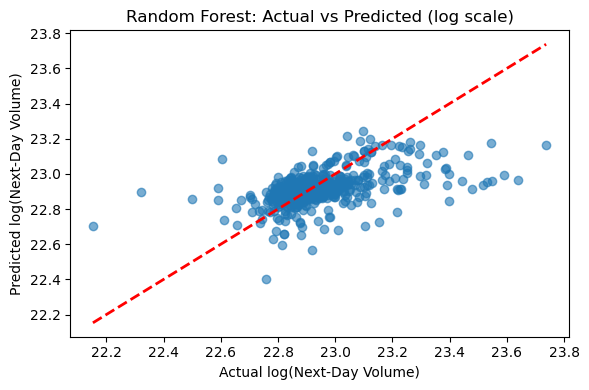

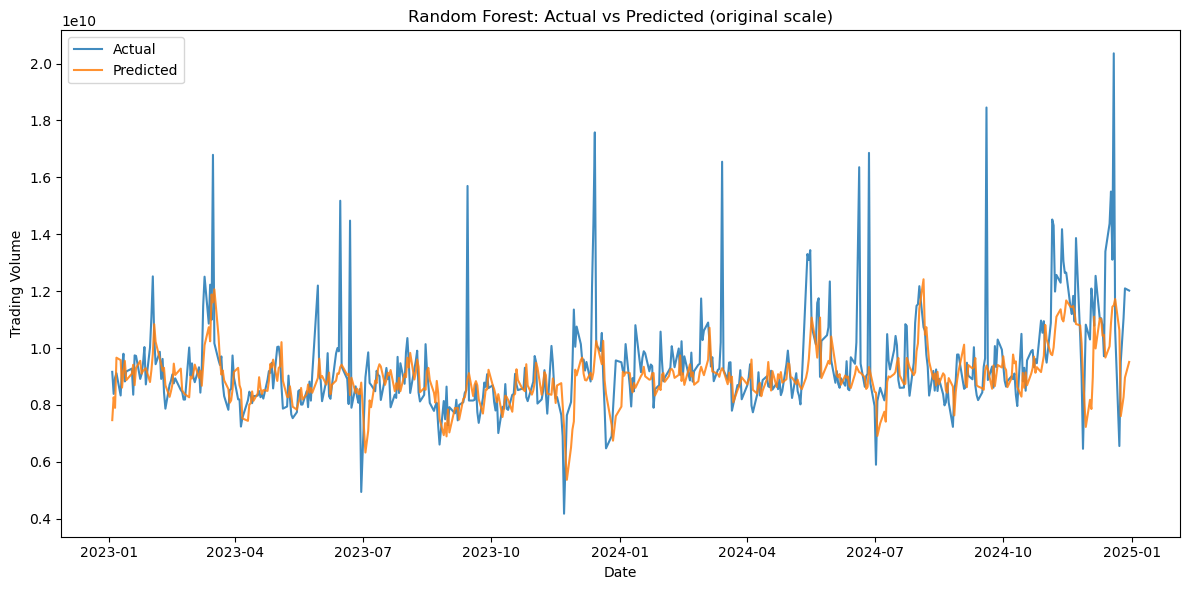

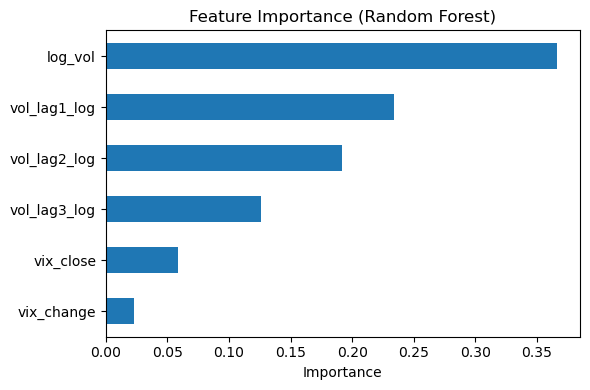

In [7]:

# =====================================================
# 6) VISUALIZATION
# =====================================================
# --- Actual vs Predicted (log scale) ---
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred, alpha=0.6)
lo, hi = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
plt.plot([lo, hi], [lo, hi], 'r--', lw=2)
plt.xlabel("Actual log(Next-Day Volume)")
plt.ylabel("Predicted log(Next-Day Volume)")
plt.title("Random Forest: Actual vs Predicted (log scale)")
plt.tight_layout()
plt.show()

# --- Time series (original scale) ---
plot_df = test.copy()
plot_df["actual_volume"] = actual
plot_df["predicted_volume"] = pred

plt.figure(figsize=(12,6))
plt.plot(plot_df["date"], plot_df["actual_volume"], label="Actual", alpha=0.85)
plt.plot(plot_df["date"], plot_df["predicted_volume"], label="Predicted", alpha=0.85)
plt.xlabel("Date")
plt.ylabel("Trading Volume")
plt.title("Random Forest: Actual vs Predicted (original scale)")
plt.legend()
plt.tight_layout()
plt.show()

# --- Feature importance ---
importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values()
plt.figure(figsize=(6,4))
importances.plot(kind="barh")
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()
